In [1]:
!pip install ucimlrepo optuna
!pip install --upgrade --user hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.2 MB/s eta 0:00:00


In [14]:
from ucimlrepo import fetch_ucirepo
import optuna
import pandas as pd
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM, CategoricalHMM
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import fetch_openml



In [37]:
def plot_roc_auc(y_true, y_score, name):
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=1, label=f'ROC Curve (AUC={roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {name} (Binary Classification)')
    plt.legend(loc='lower right')
    plt.show()

In [17]:
def load_train_breast_cancer():
  X, y = load_breast_cancer(return_X_y=True)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)


  pca = PCA(n_components= 5)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)

  discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
  cX_train = discretizer.fit_transform(X_train).astype(int)
  cX_test = discretizer.transform(X_test).astype(int)

  X_train_0 = X_train[y_train==0]
  X_train_1 = X_train[y_train==1]

  ghmm0 = GaussianHMM(n_components=3, covariance_type='full', n_iter=500).fit(X_train_0)
  ghmm1 = GaussianHMM(n_components=3, covariance_type='full', n_iter=500).fit(X_train_1)

  ghmm0.fit(X_train_0)
  ghmm1.fit(X_train_1)

  n_symbols = int(np.max([np.max(cX_train[y_train==0]), np.max(cX_train[y_train==1])]) + 1)

  chmm0 = CategoricalHMM(n_components=3, n_iter=500, random_state=42, n_features=n_symbols)
  chmm1 = CategoricalHMM(n_components=3, n_iter=500, random_state=42, n_features=n_symbols)

  chmm0.fit(cX_train[y_train==0])
  chmm1.fit(cX_train[y_train==1])

  gpreds = []
  for x in X_test:
      score0 = ghmm0.score([x])
      score1 = ghmm1.score([x])
      gpreds.append(1 if score1 > score0 else 0)

  gacc = np.mean(gpreds == y_test)

  cpreds = []
  for x in cX_test:
      score0 = chmm0.score([x])
      score1 = chmm1.score([x])
      cpreds.append(1 if score1 > score0 else 0)

  cacc= np.mean(cpreds==y_test)

  print(f"Accuracy for Gaussian HMM: {gacc*100:.2f}%")
  print(classification_report(y_test, gpreds))

  print(f"Accuracy for Multinomial HMM: {cacc*100:.2f}%")
  print(classification_report(y_test, cpreds))

In [18]:
load_train_breast_cancer()

Accuracy for Gaussian HMM: 90.35%
              precision    recall  f1-score   support

           0       0.81      0.98      0.88        43
           1       0.98      0.86      0.92        71

    accuracy                           0.90       114
   macro avg       0.90      0.92      0.90       114
weighted avg       0.92      0.90      0.90       114

Accuracy for Multinomial HMM: 70.18%
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        43
           1       0.81      0.68      0.74        71

    accuracy                           0.70       114
   macro avg       0.70      0.71      0.70       114
weighted avg       0.73      0.70      0.71       114



In [19]:
def load_train_ionosphere():
  #from sklearn.datasets import fetch_openml
  iono = fetch_openml(name="ionosphere", version=1, as_frame=True)
  X = iono.data.values
  y = np.array([1 if v == 'g' else 0 for v in iono.target])

  print(X.shape, y.shape)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)


  pca = PCA(n_components= 5)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)

  from sklearn.preprocessing import KBinsDiscretizer
  discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
  cX_train = discretizer.fit_transform(X_train).astype(int)
  cX_test = discretizer.transform(X_test).astype(int)

  X_train_0 = X_train[y_train==0]
  X_train_1 = X_train[y_train==1]

  ghmm0 = GaussianHMM(n_components=3, covariance_type='full', n_iter=500).fit(X_train_0)
  ghmm1 = GaussianHMM(n_components=3, covariance_type='full', n_iter=500).fit(X_train_1)

  ghmm0.fit(X_train_0)
  ghmm1.fit(X_train_1)

  n_symbols = int(np.max([np.max(cX_train[y_train==0]), np.max(cX_train[y_train==1])]) + 1)

  chmm0 = CategoricalHMM(n_components=3, n_iter=500, random_state=42, n_features=n_symbols)
  chmm1 = CategoricalHMM(n_components=3, n_iter=500, random_state=42, n_features=n_symbols)

  chmm0.fit(cX_train[y_train==0])
  chmm1.fit(cX_train[y_train==1])

  gpreds = []
  for x in X_test:
      score0 = ghmm0.score([x])
      score1 = ghmm1.score([x])
      gpreds.append(1 if score1 > score0 else 0)

  gacc = np.mean(gpreds == y_test)

  cpreds = []
  for x in cX_test:
      score0 = chmm0.score([x])
      score1 = chmm1.score([x])
      cpreds.append(1 if score1 > score0 else 0)

  cacc= np.mean(cpreds==y_test)

  print(f"Accuracy for Gaussian HMM: {gacc*100:.2f}%")
  print(classification_report(y_test, gpreds))

  print(f"Accuracy for Multinomial HMM: {cacc*100:.2f}%")
  print(classification_report(y_test, cpreds))

In [20]:
load_train_ionosphere()

(351, 34) (351,)
Accuracy for Gaussian HMM: 70.42%
              precision    recall  f1-score   support

           0       0.57      0.96      0.72        28
           1       0.96      0.53      0.69        43

    accuracy                           0.70        71
   macro avg       0.77      0.75      0.70        71
weighted avg       0.81      0.70      0.70        71

Accuracy for Multinomial HMM: 56.34%
              precision    recall  f1-score   support

           0       0.47      0.75      0.58        28
           1       0.73      0.44      0.55        43

    accuracy                           0.56        71
   macro avg       0.60      0.60      0.56        71
weighted avg       0.63      0.56      0.56        71



In [21]:
class OptunaGaussianTuning:
    def __init__(self,x_train, y_train, x_test, y_test):
        self.x_train= x_train
        self.x_test= x_test
        self.y_train= y_train
        self.y_test= y_test

    def objective_model(self, trial):
        n_components= trial.suggest_int("n_components", 1, 10)
        covariance_type= trial.suggest_categorical("covariance_type", ["full", "tied", "diag", "spherical"])
        n_iter= trial.suggest_int("n_iter", 100, 1000)

        hmm0= hmm.GaussianHMM(n_components= n_components, covariance_type= covariance_type, n_iter= n_iter)
        hmm1= hmm.GaussianHMM(n_components= n_components, covariance_type= covariance_type, n_iter= n_iter)

        x0_train= self.x_train[self.y_train==0]
        x1_train= self.x_train[self.y_train==1]

        hmm0.fit(x0_train)
        hmm1.fit(x1_train)

        preds= []
        for x in self.x_test:
            score0= hmm0.score([x])
            score1= hmm1.score([x])
            preds.append(1 if score1 > score0 else 0)


        acc= np.mean(preds== self.y_test)
        return acc


    def objective(self):
      study= optuna.create_study(direction= "maximize")
      study.optimize(self.objective_model, n_trials=25, n_jobs=-1)
      return study


class OptunaCategoricalTuning:
    def __init__(self,x_train, y_train, x_test, y_test):
        self.x_train= x_train
        self.x_test= x_test
        self.y_train= y_train
        self.y_test= y_test


    def objective_model(self, trial):
        n_components= trial.suggest_int("n_components", 1, 10)
        n_iter= trial.suggest_int("n_iter", 100, 1000)

        x0_train= self.x_train[self.y_train==0]
        x1_train= self.x_train[self.y_train==1]
        n_symbols= int(np.max([np.max(x0_train), np.max(x1_train)]) + 1)

        hmm0= hmm.CategoricalHMM(n_components= n_components, n_iter= n_iter, random_state= 42, n_features= n_symbols)
        hmm1= hmm.CategoricalHMM(n_components= n_components, n_iter= n_iter, random_state= 42, n_features= n_symbols)

        hmm0.fit(x0_train)
        hmm1.fit(x1_train)

        preds= []
        for x in self.x_test:
            score0= hmm0.score([x])
            score1= hmm1.score([x])
            preds.append(1 if score1 > score0 else 0)


        acc= np.mean(preds== self.y_test)
        return acc


    def objective(self):
      study= optuna.create_study(direction= "maximize")
      study.optimize(self.objective_model, n_trials=25, n_jobs=-1)
      return study

In [22]:
import os
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {name}')


    plt.show()

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, fetch_openml
from hmmlearn.hmm import GaussianHMM, CategoricalHMM
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def load_datasets():
    X_bc, y_bc = load_breast_cancer(return_X_y=True, as_frame=False)


    iono = fetch_openml(name="ionosphere", version=1, as_frame=True)
    X_iono = iono.data.values
    y_iono = np.array([1 if v == 'g' else 0 for v in iono.target])

    return (X_bc, y_bc, "BreastCancer"), (X_iono, y_iono, "Ionosphere")


def train_hmm(X_train, X_test, y_train, y_test, model_type="gaussian", n_components=3, pca_dim=5):

    if model_type == "gaussian":
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        if X_train.shape[1] > pca_dim:
            pca = PCA(n_components=pca_dim)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)


    if model_type == "multinomial":

        discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        X_train = discretizer.fit_transform(X_train).astype(int)
        X_test = discretizer.transform(X_test).astype(int)

    X0 = X_train[y_train == 0]
    X1 = X_train[y_train == 1]

    print(f"X0 shape: {X0.shape}")
    print(f"X1 shape: {X1.shape}")

    if model_type == "gaussian":
        optuna_tuning= OptunaGaussianTuning(X_train, y_train, X_test, y_test)
        params= optuna_tuning.objective()
        n_components= params.best_params["n_components"]
        covariance_type= params.best_params["covariance_type"]
        n_iter= params.best_params["n_iter"]
        model0 = GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter, random_state=42)
        model1 = GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter, random_state=42)
    else:

        n_symbols = int(np.max([np.max(X0), np.max(X1)]) + 1)
        optuna_tuning= OptunaCategoricalTuning(X_train, y_train, X_test, y_test)
        params= optuna_tuning.objective()
        n_components= params.best_params["n_components"]
        n_iter= params.best_params["n_iter"]
        model0 = CategoricalHMM(n_components=n_components, n_iter=n_iter, random_state=42, n_features=n_symbols)
        model1 = CategoricalHMM(n_components=n_components, n_iter=n_iter, random_state=42, n_features=n_symbols)



    model0.fit(X0)
    model1.fit(X1)


    y_pred = []
    for x in X_test:

        x = np.expand_dims(x, axis=0)
        try:
            score0 = model0.score(x)
            score1 = model1.score(x)
        except ValueError:
            score0, score1 = -np.inf, -np.inf

        y_pred.append(1 if score1 > score0 else 0)

    if model_type!='gaussian':
      return accuracy_score(y_test, y_pred), n_components, n_iter, None
    else:
      return accuracy_score(y_test, y_pred), n_components, n_iter, covariance_type


def run_experiments():
    datasets = load_datasets()
    test_sizes = [0.2, 0.1, 0.3]
    models = ["gaussian", "multinomial"]
    results = []

    for X, y, name in datasets:
        for test_size in test_sizes:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
            for model_type in models:
                acc, n_components, n_iter, covariance_type  = train_hmm(X_train, X_test, y_train, y_test, model_type, n_components=4, pca_dim=6)
                results.append({
                    "Dataset": name,
                    "Model": model_type.title(),
                    "Test_Size": f"{int(test_size*100)}-{int((1-test_size)*100)}",
                    "Accuracy": round(acc*100, 2),
                    "n_components": n_components,
                    "n_iter": n_iter,
                    "covariance_type": 'NAN' if covariance_type is None else covariance_type
                })


    df = pd.DataFrame(results)
    return df


In [24]:
# Run all experiments
results_df = run_experiments()

[I 2025-10-06 04:36:38,162] A new study created in memory with name: no-name-06165daf-4482-4350-990e-239ae8f34a65
[I 2025-10-06 04:36:38,276] Trial 0 finished with value: 0.9035087719298246 and parameters: {'n_components': 1, 'covariance_type': 'diag', 'n_iter': 500}. Best is trial 0 with value: 0.9035087719298246.


X0 shape: (170, 6)
X1 shape: (285, 6)


[I 2025-10-06 04:36:38,492] Trial 2 finished with value: 0.8771929824561403 and parameters: {'n_components': 2, 'covariance_type': 'diag', 'n_iter': 925}. Best is trial 0 with value: 0.9035087719298246.
[I 2025-10-06 04:36:38,680] Trial 1 finished with value: 0.8947368421052632 and parameters: {'n_components': 5, 'covariance_type': 'spherical', 'n_iter': 954}. Best is trial 0 with value: 0.9035087719298246.
[I 2025-10-06 04:36:39,305] Trial 4 finished with value: 0.9122807017543859 and parameters: {'n_components': 8, 'covariance_type': 'diag', 'n_iter': 853}. Best is trial 4 with value: 0.9122807017543859.
[I 2025-10-06 04:36:39,394] Trial 5 finished with value: 0.9035087719298246 and parameters: {'n_components': 1, 'covariance_type': 'diag', 'n_iter': 582}. Best is trial 4 with value: 0.9122807017543859.
[I 2025-10-06 04:36:40,211] Trial 3 finished with value: 0.868421052631579 and parameters: {'n_components': 10, 'covariance_type': 'tied', 'n_iter': 887}. Best is trial 4 with value: 

X0 shape: (170, 30)
X1 shape: (285, 30)


[I 2025-10-06 04:36:50,677] Trial 0 finished with value: 0.9298245614035088 and parameters: {'n_components': 3, 'n_iter': 279}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-10-06 04:37:00,692] Trial 2 finished with value: 0.868421052631579 and parameters: {'n_components': 4, 'n_iter': 429}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-10-06 04:37:01,763] Trial 3 finished with value: 0.8771929824561403 and parameters: {'n_components': 2, 'n_iter': 831}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-10-06 04:37:10,073] Trial 1 finished with value: 0.9210526315789473 and parameters: {'n_components': 9, 'n_iter': 155}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-10-06 04:37:41,767] Trial 4 finished with value: 0.6491228070175439 and parameters: {'n_components': 8, 'n_iter': 586}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-10-06 04:37:43,229] Trial 5 finished with value: 0.6666666666666666 and parameters: {'n_components': 8, 'n_iter':

X0 shape: (191, 6)
X1 shape: (321, 6)


[I 2025-10-06 04:39:36,969] Trial 0 finished with value: 0.9122807017543859 and parameters: {'n_components': 2, 'covariance_type': 'tied', 'n_iter': 322}. Best is trial 0 with value: 0.9122807017543859.
[I 2025-10-06 04:39:37,310] Trial 2 finished with value: 0.7894736842105263 and parameters: {'n_components': 4, 'covariance_type': 'full', 'n_iter': 360}. Best is trial 0 with value: 0.9122807017543859.
[I 2025-10-06 04:39:37,467] Trial 1 finished with value: 0.5789473684210527 and parameters: {'n_components': 6, 'covariance_type': 'diag', 'n_iter': 640}. Best is trial 0 with value: 0.9122807017543859.
[I 2025-10-06 04:39:38,081] Trial 3 finished with value: 0.8947368421052632 and parameters: {'n_components': 9, 'covariance_type': 'spherical', 'n_iter': 486}. Best is trial 0 with value: 0.9122807017543859.
[I 2025-10-06 04:39:38,538] Trial 4 finished with value: 0.9473684210526315 and parameters: {'n_components': 8, 'covariance_type': 'tied', 'n_iter': 935}. Best is trial 4 with value: 

X0 shape: (191, 30)
X1 shape: (321, 30)


[I 2025-10-06 04:39:48,324] Trial 0 finished with value: 0.8947368421052632 and parameters: {'n_components': 2, 'n_iter': 623}. Best is trial 0 with value: 0.8947368421052632.
[I 2025-10-06 04:39:50,292] Trial 2 finished with value: 0.9298245614035088 and parameters: {'n_components': 3, 'n_iter': 687}. Best is trial 2 with value: 0.9298245614035088.
[I 2025-10-06 04:40:28,079] Trial 3 finished with value: 0.9122807017543859 and parameters: {'n_components': 5, 'n_iter': 932}. Best is trial 2 with value: 0.9298245614035088.
[I 2025-10-06 04:40:37,165] Trial 4 finished with value: 0.8421052631578947 and parameters: {'n_components': 4, 'n_iter': 602}. Best is trial 2 with value: 0.9298245614035088.
[I 2025-10-06 04:40:39,145] Trial 5 finished with value: 0.9298245614035088 and parameters: {'n_components': 3, 'n_iter': 208}. Best is trial 2 with value: 0.9298245614035088.
[I 2025-10-06 04:40:56,324] Trial 1 finished with value: 0.9649122807017544 and parameters: {'n_components': 8, 'n_iter'

X0 shape: (148, 6)
X1 shape: (250, 6)


[I 2025-10-06 04:49:44,230] Trial 1 finished with value: 0.7134502923976608 and parameters: {'n_components': 5, 'covariance_type': 'diag', 'n_iter': 533}. Best is trial 1 with value: 0.7134502923976608.
[I 2025-10-06 04:49:44,354] Trial 2 finished with value: 0.9239766081871345 and parameters: {'n_components': 1, 'covariance_type': 'diag', 'n_iter': 663}. Best is trial 2 with value: 0.9239766081871345.
[I 2025-10-06 04:49:44,685] Trial 0 finished with value: 0.935672514619883 and parameters: {'n_components': 5, 'covariance_type': 'tied', 'n_iter': 613}. Best is trial 0 with value: 0.935672514619883.
[I 2025-10-06 04:49:45,630] Trial 3 finished with value: 0.6081871345029239 and parameters: {'n_components': 9, 'covariance_type': 'tied', 'n_iter': 843}. Best is trial 0 with value: 0.935672514619883.
[I 2025-10-06 04:49:46,174] Trial 5 finished with value: 0.3742690058479532 and parameters: {'n_components': 9, 'covariance_type': 'full', 'n_iter': 389}. Best is trial 0 with value: 0.935672

X0 shape: (148, 30)
X1 shape: (250, 30)


[I 2025-10-06 04:50:15,231] Trial 1 finished with value: 0.9415204678362573 and parameters: {'n_components': 6, 'n_iter': 537}. Best is trial 1 with value: 0.9415204678362573.
[I 2025-10-06 04:50:15,271] Trial 0 finished with value: 0.9415204678362573 and parameters: {'n_components': 6, 'n_iter': 915}. Best is trial 1 with value: 0.9415204678362573.
[I 2025-10-06 04:50:39,820] Trial 2 finished with value: 0.8771929824561403 and parameters: {'n_components': 10, 'n_iter': 172}. Best is trial 1 with value: 0.9415204678362573.
[I 2025-10-06 04:50:41,491] Trial 4 finished with value: 0.9298245614035088 and parameters: {'n_components': 3, 'n_iter': 178}. Best is trial 1 with value: 0.9415204678362573.
[I 2025-10-06 04:50:54,634] Trial 3 finished with value: 0.9532163742690059 and parameters: {'n_components': 8, 'n_iter': 716}. Best is trial 3 with value: 0.9532163742690059.
[I 2025-10-06 04:51:21,675] Trial 6 finished with value: 0.9473684210526315 and parameters: {'n_components': 9, 'n_iter

X0 shape: (101, 6)
X1 shape: (179, 6)


[I 2025-10-06 04:57:24,125] Trial 1 finished with value: 0.8450704225352113 and parameters: {'n_components': 8, 'covariance_type': 'diag', 'n_iter': 311}. Best is trial 1 with value: 0.8450704225352113.
[I 2025-10-06 04:57:24,556] Trial 2 finished with value: 0.8732394366197183 and parameters: {'n_components': 10, 'covariance_type': 'full', 'n_iter': 824}. Best is trial 2 with value: 0.8732394366197183.
[I 2025-10-06 04:57:24,768] Trial 0 finished with value: 0.7887323943661971 and parameters: {'n_components': 6, 'covariance_type': 'tied', 'n_iter': 874}. Best is trial 2 with value: 0.8732394366197183.
[I 2025-10-06 04:57:25,041] Trial 4 finished with value: 0.8169014084507042 and parameters: {'n_components': 3, 'covariance_type': 'tied', 'n_iter': 221}. Best is trial 2 with value: 0.8732394366197183.
[I 2025-10-06 04:57:25,359] Trial 3 finished with value: 0.5633802816901409 and parameters: {'n_components': 6, 'covariance_type': 'full', 'n_iter': 117}. Best is trial 2 with value: 0.87

X0 shape: (101, 34)
X1 shape: (179, 34)


[I 2025-10-06 04:57:30,516] Trial 1 finished with value: 0.8450704225352113 and parameters: {'n_components': 2, 'n_iter': 621}. Best is trial 1 with value: 0.8450704225352113.
[I 2025-10-06 04:57:34,862] Trial 2 finished with value: 0.9154929577464789 and parameters: {'n_components': 5, 'n_iter': 614}. Best is trial 2 with value: 0.9154929577464789.
[I 2025-10-06 04:57:49,116] Trial 3 finished with value: 0.9295774647887324 and parameters: {'n_components': 9, 'n_iter': 360}. Best is trial 3 with value: 0.9295774647887324.
[I 2025-10-06 04:57:56,896] Trial 4 finished with value: 0.9154929577464789 and parameters: {'n_components': 10, 'n_iter': 700}. Best is trial 3 with value: 0.9295774647887324.
[I 2025-10-06 04:58:01,034] Trial 6 finished with value: 0.9154929577464789 and parameters: {'n_components': 6, 'n_iter': 356}. Best is trial 3 with value: 0.9295774647887324.
[I 2025-10-06 04:58:07,406] Trial 7 finished with value: 0.9154929577464789 and parameters: {'n_components': 5, 'n_iter

X0 shape: (113, 6)
X1 shape: (202, 6)


[I 2025-10-06 04:59:55,743] Trial 3 finished with value: 0.4444444444444444 and parameters: {'n_components': 10, 'covariance_type': 'diag', 'n_iter': 510}. Best is trial 2 with value: 0.8611111111111112.
[I 2025-10-06 04:59:56,268] Trial 0 finished with value: 0.4444444444444444 and parameters: {'n_components': 10, 'covariance_type': 'tied', 'n_iter': 883}. Best is trial 2 with value: 0.8611111111111112.
[I 2025-10-06 04:59:56,443] Trial 4 finished with value: 0.4166666666666667 and parameters: {'n_components': 9, 'covariance_type': 'tied', 'n_iter': 293}. Best is trial 2 with value: 0.8611111111111112.
[I 2025-10-06 04:59:56,589] Trial 6 finished with value: 0.5277777777777778 and parameters: {'n_components': 2, 'covariance_type': 'full', 'n_iter': 206}. Best is trial 2 with value: 0.8611111111111112.
[I 2025-10-06 04:59:56,733] Trial 7 finished with value: 0.75 and parameters: {'n_components': 3, 'covariance_type': 'spherical', 'n_iter': 264}. Best is trial 2 with value: 0.8611111111

X0 shape: (113, 34)
X1 shape: (202, 34)


[I 2025-10-06 05:00:00,898] Trial 0 finished with value: 0.8055555555555556 and parameters: {'n_components': 3, 'n_iter': 792}. Best is trial 0 with value: 0.8055555555555556.
[I 2025-10-06 05:00:02,027] Trial 2 finished with value: 0.8333333333333334 and parameters: {'n_components': 2, 'n_iter': 905}. Best is trial 2 with value: 0.8333333333333334.
[I 2025-10-06 05:00:03,646] Trial 3 finished with value: 0.8333333333333334 and parameters: {'n_components': 2, 'n_iter': 765}. Best is trial 2 with value: 0.8333333333333334.
[I 2025-10-06 05:00:12,322] Trial 1 finished with value: 0.8611111111111112 and parameters: {'n_components': 5, 'n_iter': 536}. Best is trial 1 with value: 0.8611111111111112.
[I 2025-10-06 05:00:14,049] Trial 4 finished with value: 0.8611111111111112 and parameters: {'n_components': 8, 'n_iter': 164}. Best is trial 1 with value: 0.8611111111111112.
[I 2025-10-06 05:00:24,847] Trial 6 finished with value: 0.8611111111111112 and parameters: {'n_components': 8, 'n_iter'

X0 shape: (88, 6)
X1 shape: (157, 6)


[I 2025-10-06 05:02:21,108] Trial 2 finished with value: 0.7075471698113207 and parameters: {'n_components': 4, 'covariance_type': 'diag', 'n_iter': 173}. Best is trial 1 with value: 0.7358490566037735.
[I 2025-10-06 05:02:21,261] Trial 0 finished with value: 0.5754716981132075 and parameters: {'n_components': 9, 'covariance_type': 'diag', 'n_iter': 304}. Best is trial 1 with value: 0.7358490566037735.
[I 2025-10-06 05:02:21,568] Trial 3 finished with value: 0.5943396226415094 and parameters: {'n_components': 6, 'covariance_type': 'spherical', 'n_iter': 463}. Best is trial 1 with value: 0.7358490566037735.
[I 2025-10-06 05:02:22,117] Trial 5 finished with value: 0.7358490566037735 and parameters: {'n_components': 7, 'covariance_type': 'tied', 'n_iter': 948}. Best is trial 1 with value: 0.7358490566037735.
[I 2025-10-06 05:02:22,340] Trial 4 finished with value: 0.7358490566037735 and parameters: {'n_components': 10, 'covariance_type': 'tied', 'n_iter': 768}. Best is trial 1 with value:

X0 shape: (88, 34)
X1 shape: (157, 34)


[I 2025-10-06 05:02:40,969] Trial 0 finished with value: 0.9150943396226415 and parameters: {'n_components': 8, 'n_iter': 514}. Best is trial 0 with value: 0.9150943396226415.
[I 2025-10-06 05:02:41,052] Trial 2 finished with value: 0.7169811320754716 and parameters: {'n_components': 1, 'n_iter': 913}. Best is trial 0 with value: 0.9150943396226415.
[I 2025-10-06 05:02:44,411] Trial 3 finished with value: 0.8773584905660378 and parameters: {'n_components': 6, 'n_iter': 219}. Best is trial 0 with value: 0.9150943396226415.
[I 2025-10-06 05:02:45,370] Trial 4 finished with value: 0.8207547169811321 and parameters: {'n_components': 2, 'n_iter': 318}. Best is trial 0 with value: 0.9150943396226415.
[I 2025-10-06 05:02:45,556] Trial 1 finished with value: 0.8773584905660378 and parameters: {'n_components': 10, 'n_iter': 276}. Best is trial 0 with value: 0.9150943396226415.
[I 2025-10-06 05:02:45,640] Trial 6 finished with value: 0.7169811320754716 and parameters: {'n_components': 1, 'n_iter

In [25]:
print("\nSummary")
print(results_df)


Summary
         Dataset        Model Test_Size  Accuracy  n_components  n_iter  \
0   BreastCancer     Gaussian     20-80     92.11             6     222   
1   BreastCancer  Multinomial     20-80     92.98             3     279   
2   BreastCancer     Gaussian     10-90     98.25            10     436   
3   BreastCancer  Multinomial     10-90     96.49             8     972   
4   BreastCancer     Gaussian     30-70     77.78             4     132   
5   BreastCancer  Multinomial     30-70     95.32             8     716   
6     Ionosphere     Gaussian     20-80     94.37             1     376   
7     Ionosphere  Multinomial     20-80     92.96             9     360   
8     Ionosphere     Gaussian     10-90     91.67             3     101   
9     Ionosphere  Multinomial     10-90     94.44             7     951   
10    Ionosphere     Gaussian     30-70     92.45             1     109   
11    Ionosphere  Multinomial     30-70     91.51             8     514   

   covariance_t

In [26]:
parameters= {
    "BreastCancer":{
        "test_size": 0.1,
        "n_components": 10,
        "n_iter": 436,
        "covariance_type": "spherical",
        "model_type": "gaussian"
    },
    "Ionosphere": {
        "test_size": 0.1,
        "n_components": 7,
        "n_iter": 951,
        "model_type": "multinomial"
    }
}

In [41]:
import os
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

def train_best_(parameters):
  datasets = load_datasets()

  for X, y, name in datasets:
    params = parameters[name]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=params["test_size"], random_state=42, stratify=y)


    if params["model_type"] == "gaussian":
      scaler = StandardScaler()
      x_train_processed = scaler.fit_transform(x_train)
      x_test_processed = scaler.transform(x_test)


      pca = PCA(n_components=6)
      x_train_processed = pca.fit_transform(x_train_processed)
      x_test_processed = pca.transform(x_test_processed)

      model0 = GaussianHMM(n_components=params["n_components"], covariance_type=params["covariance_type"], n_iter=params["n_iter"], random_state=42)
      model1 = GaussianHMM(n_components=params["n_components"], covariance_type=params["covariance_type"], n_iter=params["n_iter"], random_state=42)

      x0_train = x_train_processed[y_train == 0]
      x1_train = x_train_processed[y_train == 1]

      model0.fit(x0_train)
      model1.fit(x1_train)

      preds = []
      preds_prob = []
      for x in x_test_processed:
        x = np.expand_dims(x, axis=0)
        score0 = model0.score(x)
        score1 = model1.score(x)
        preds.append(1 if score1 > score0 else 0)
        # Calculate pseudo-probabilities for ROC curve
        total_score = score0 + score1
        prob0 = score0 / total_score if total_score != 0 else 0.5
        prob1 = score1 / total_score if total_score != 0 else 0.5
        preds_prob.append([prob0, prob1])

      preds_prob = np.array(preds_prob)
      print(preds_prob.shape)
      acc = accuracy_score(y_test, preds)
      score_f1 = f1_score(y_test, preds)
      precision = precision_score(y_test, preds)
      recall = recall_score(y_test, preds)

      print(f"\n--- Results for {name} ({params['model_type']} model) ---")
      print(f"Accuracy: {acc*100:.2f}%")
      print(f"F1 Score: {score_f1*100:.2f}%")
      print(f"Precision: {precision*100:.2f}%")
      print(f"Recall: {recall*100:.2f}%")

      plot_confusion(y_test, preds, f'{name}_{params["test_size"]}_{params["model_type"]}')
      plot_roc_auc(y_test, preds_prob, f'{name}_{params["test_size"]}_{params["model_type"]}')


    elif params["model_type"] == "multinomial":
      discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
      x_train_processed = discretizer.fit_transform(x_train).astype(int)
      x_test_processed = discretizer.transform(x_test).astype(int)

      x0_train = x_train_processed[y_train == 0]
      x1_train = x_train_processed[y_train == 1]
      n_symbols = int(np.max([np.max(x0_train), np.max(x1_train)]) + 1)


      model0 = CategoricalHMM(n_components=params["n_components"], n_iter=params["n_iter"], random_state=42, n_features=n_symbols)
      model1 = CategoricalHMM(n_components=params["n_components"], n_iter=params["n_iter"], random_state=42, n_features=n_symbols)

      model0.fit(x0_train)
      model1.fit(x1_train)

      preds = []
      preds_prob= []
      for x in x_test_processed:
        x = np.expand_dims(x, axis=0)
        score0 = model0.score(x)
        score1 = model1.score(x)
        preds.append(1 if score1 > score0 else 0)
        # Calculate pseudo-probabilities for ROC curve
        total_score = score0 + score1
        prob0 = score0 / total_score if total_score != 0 else 0.5
        prob1 = score1 / total_score if total_score != 0 else 0.5
        preds_prob.append([prob0, prob1])

      preds_prob = np.array(preds_prob)
      acc = accuracy_score(y_test, preds)
      score_f1 = f1_score(y_test, preds)
      precision = precision_score(y_test, preds)
      recall = recall_score(y_test, preds)
      print(f"\n--- Results for {name} ({params['model_type']} model) ---")
      print(f"Accuracy: {acc*100:.2f}%")
      print(f"F1 Score: {score_f1*100:.2f}%")
      print(f"Precision: {precision*100:.2f}%")
      print(f"Recall: {recall*100:.2f}%")

      plot_confusion(y_test, preds, f'{name}_{params["test_size"]}_{params["model_type"]}')
      plot_roc_auc(y_test, preds_prob, f'{name}_{params["test_size"]}_{params["model_type"]}')

    else:
        print(f"Unknown model type: {params['model_type']}")

(57, 2)

--- Results for BreastCancer (gaussian model) ---
Accuracy: 98.25%
F1 Score: 98.63%
Precision: 97.30%
Recall: 100.00%


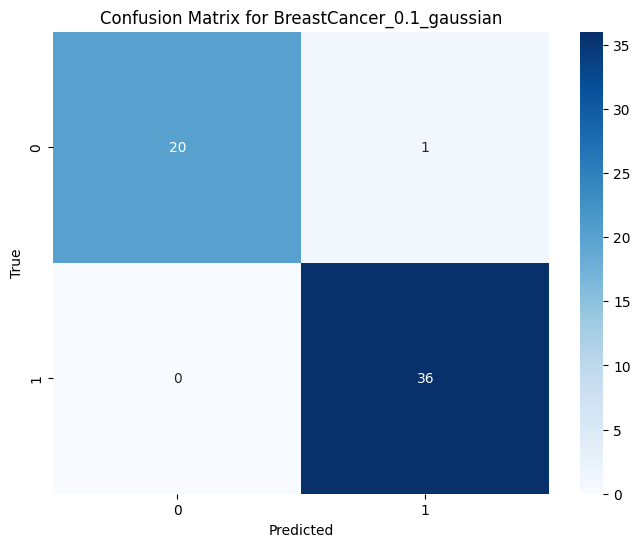

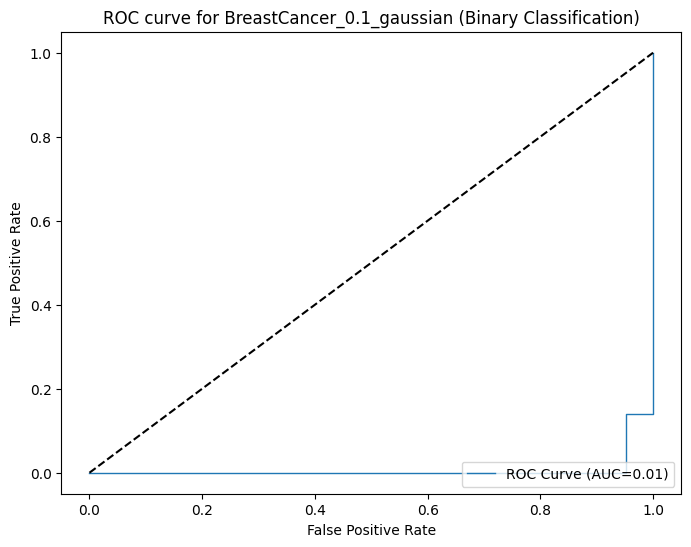

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) 


--- Results for Ionosphere (multinomial model) ---
Accuracy: 94.44%
F1 Score: 95.45%
Precision: 100.00%
Recall: 91.30%


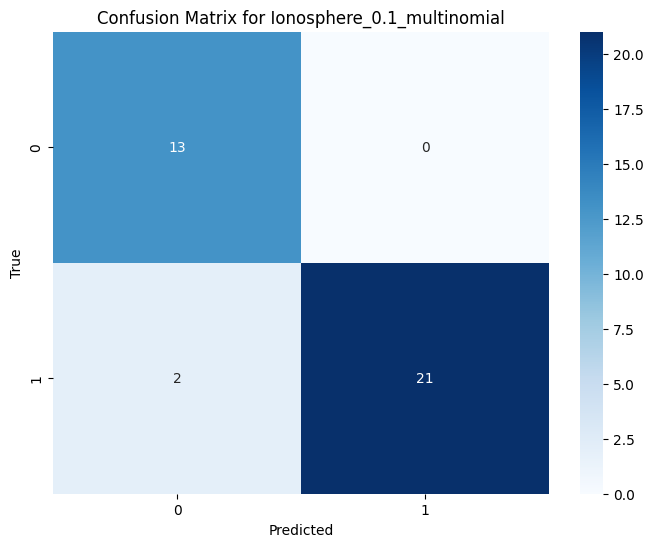

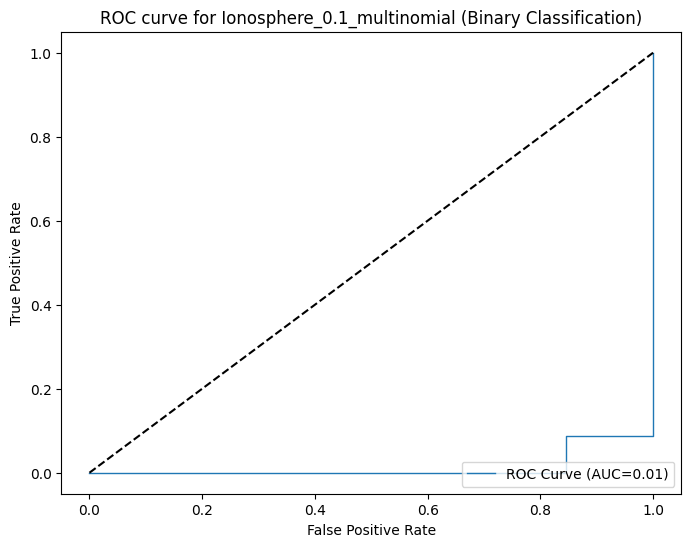

In [42]:
train_best_(parameters)